## Import necessary Libraries 

In [39]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import random
import keras as K
import tensorflow as tf
from keras.preprocessing.image import load_img, array_to_img
from keras.applications import EfficientNetB1
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils    
import scipy

## Creating Directories to store Cropped Images

In [40]:
os.makedirs('content/Crop-Brain-MRI/glioma_tumor', exist_ok=True)
os.makedirs('content/Crop-Brain-MRI/meningioma_tumor', exist_ok=True)
os.makedirs('content/Crop-Brain-MRI/pituitary_tumor', exist_ok=True)
os.makedirs('content/Crop-Brain-MRI/no_tumor', exist_ok=True)

## Data Visualization

In [41]:
train_dir = 'Coursera-Content/Brain-MRI/Training/'

In [42]:
classes = os.listdir('Coursera-Content/Brain-MRI/Training')

In [43]:
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [44]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

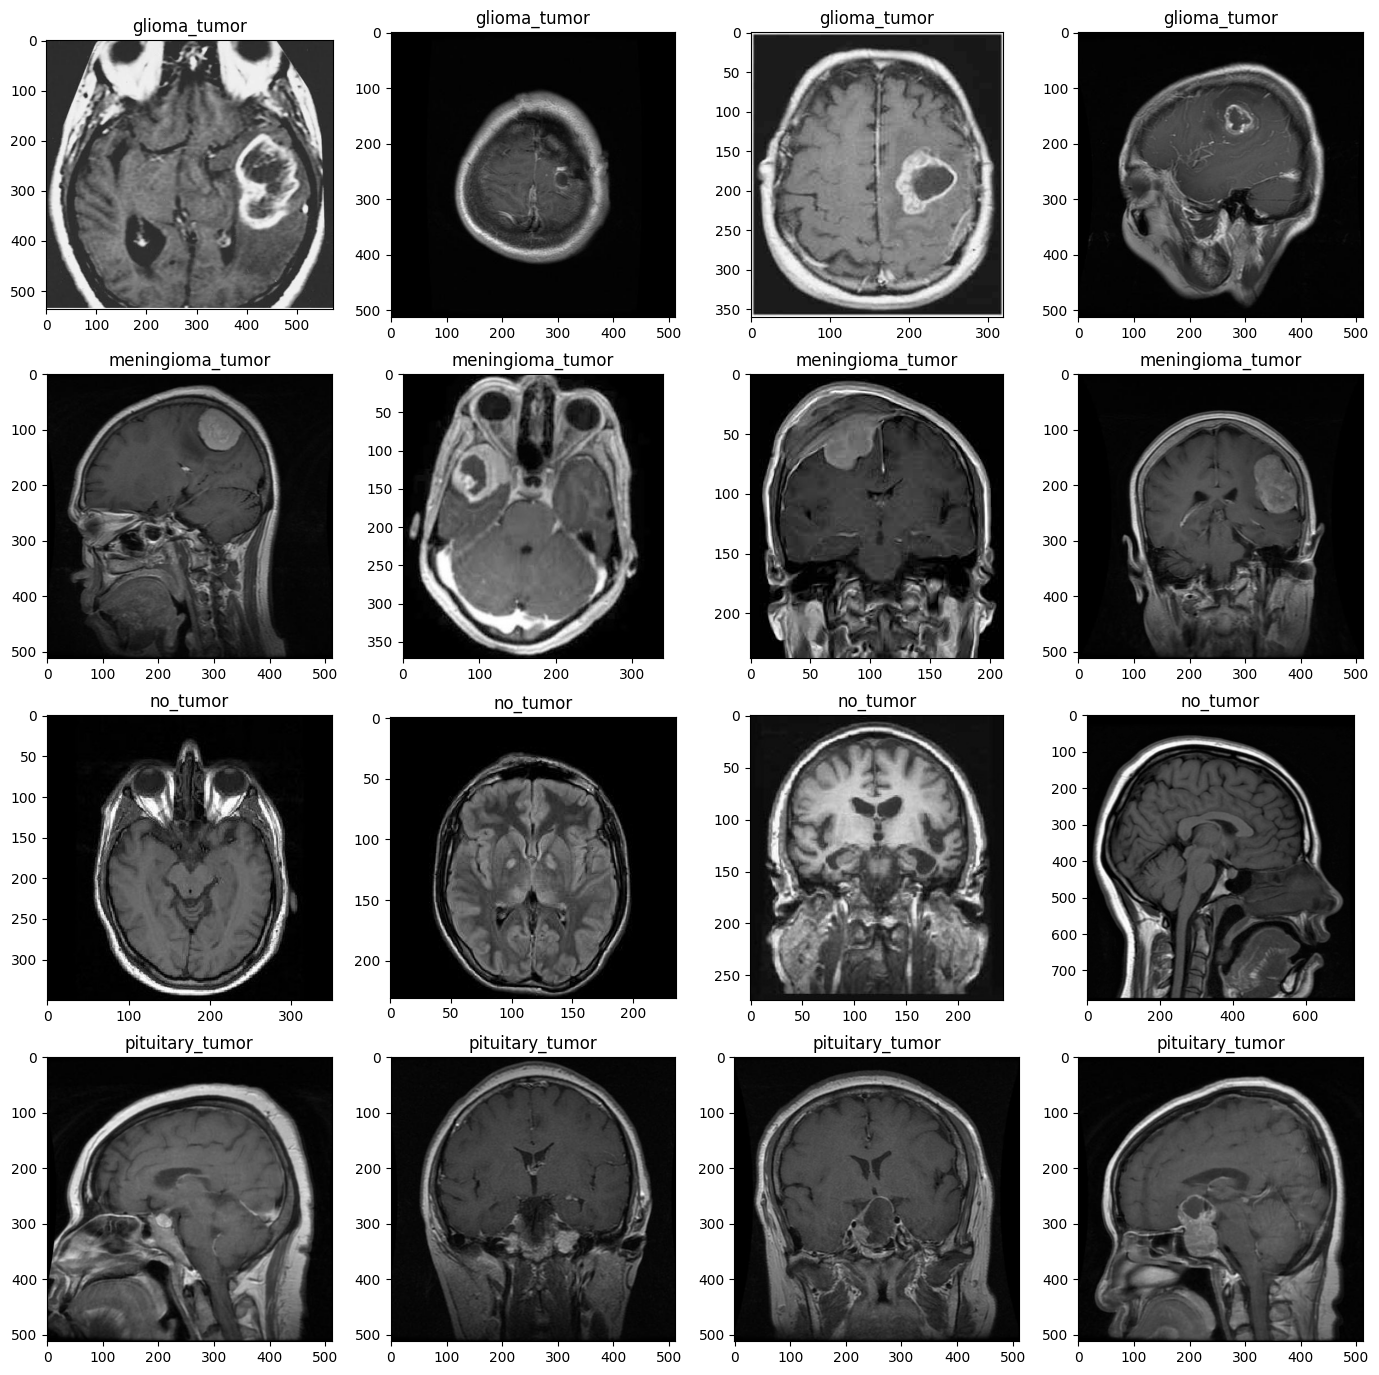

In [45]:
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

## Create a Function to Crop Images

In [46]:
def crop_image(image, plot=False):
    
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    contours = imutils.grab_contours(contours)

    
    c = max(contours, key=cv2.contourArea)

    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


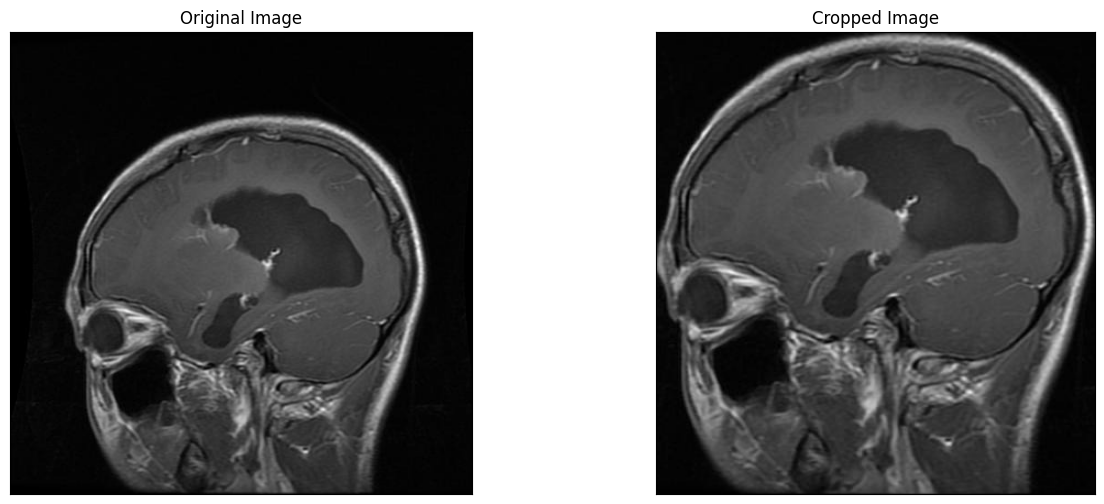

In [47]:
example_image = cv2.imread('Coursera-Content/Brain-MRI/Training/glioma_tumor/gg (61).jpg')
cropped_image = crop_image(example_image, plot=True)


## Saving The Cropped Images 

In [48]:
glioma = train_dir + 'glioma_tumor'
meningioma = train_dir + 'meningioma_tumor'
pituitary = train_dir + 'pituitary_tumor'
no_tumor = train_dir + 'no_tumor'

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'content/Crop-Brain-MRI/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'content/Crop-Brain-MRI/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'content/Crop-Brain-MRI/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'content/Crop-Brain-MRI/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

100%|██████████| 501/501 [00:01<00:00, 353.30it/s]


## Data Augmentation

In [49]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory('content/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                             class_mode='categorical',
                             subset='training')

valid_data = datagen.flow_from_directory('content/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                             class_mode='categorical',
                             subset='validation')


Found 2605 images belonging to 4 classes.
Found 650 images belonging to 4 classes.


In [50]:
#view the class dictionary
print(train_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


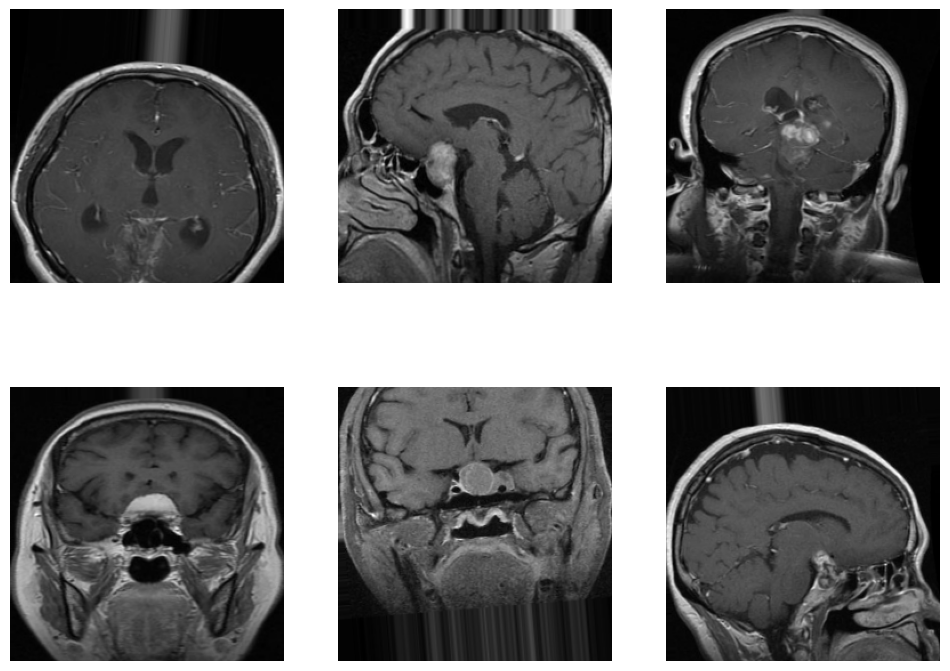

In [51]:
#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Model Architect

In [52]:
#build the model
effnet = EfficientNetB1(weights='imagenet', 
                        include_top=False, 
                        input_shape=(240, 240, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, 
              outputs=model)



## Compile Model

In [53]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('model.keras', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

## Model Training and Model Evaluation

In [54]:
 %%time

history = model.fit(train_data,
                    epochs = 10,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5177 - loss: 1.1156
Epoch 1: val_accuracy improved from -inf to 0.66462, saving model to model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.5195 - loss: 1.1124 - val_accuracy: 0.6646 - val_loss: 0.7547 - learning_rate: 1.0000e-04
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8552 - loss: 0.4163
Epoch 2: val_accuracy improved from 0.66462 to 0.72769, saving model to model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.8555 - loss: 0.4156 - val_accuracy: 0.7277 - val_loss: 0.6120 - learning_rate: 1.0000e-04
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9142 - loss: 0.2446
Epoch 3: val_accuracy improved from 0.72769 to 0.81231, saving model to model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.9142 - loss: 0.2444 - val_accuracy: 0.8123 - val_loss: 0.4976 - learning_rate: 1.0000e-04
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9492 - 

## Model Evaluation

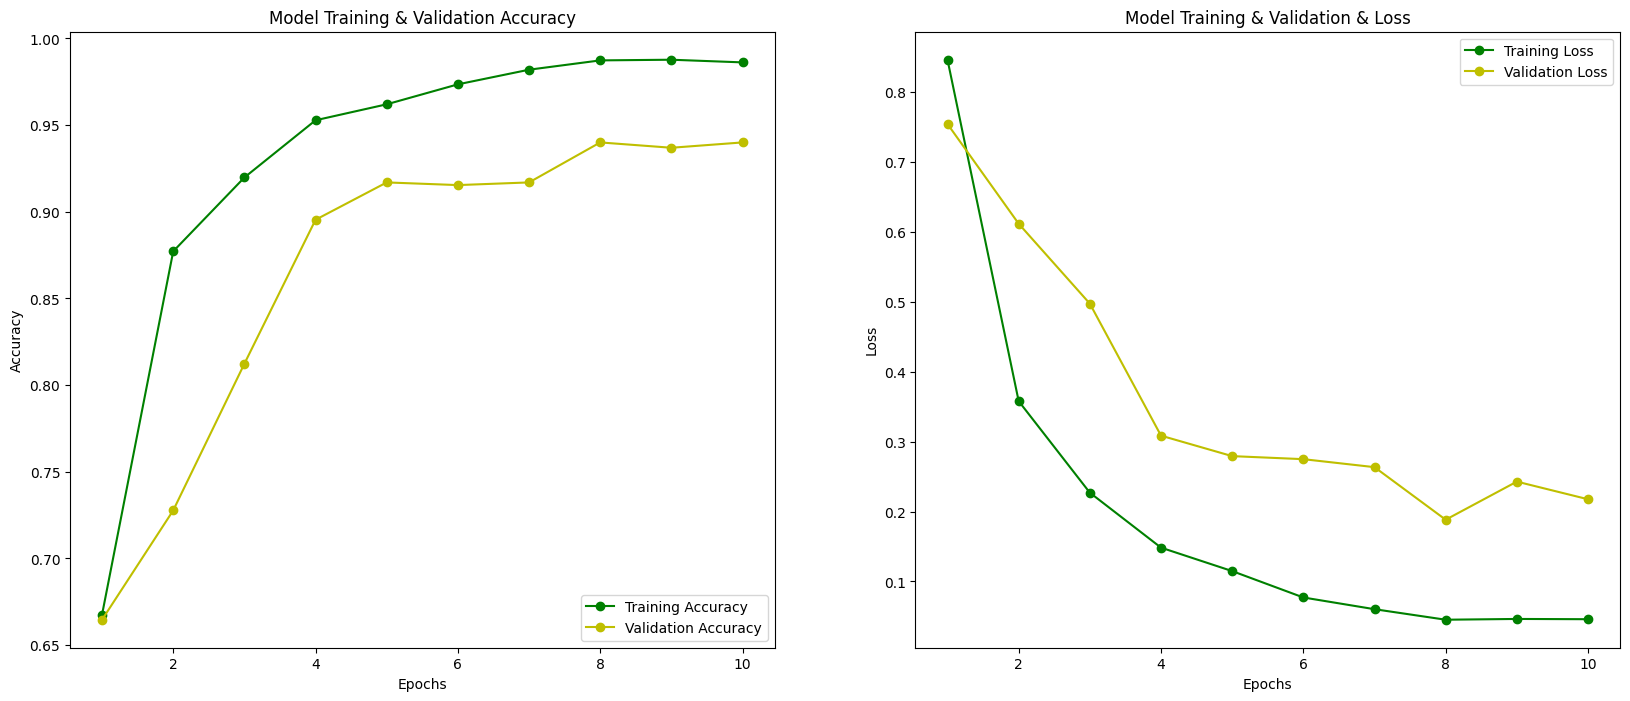

In [55]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [56]:
print('Train accuracy & loss:', model.evaluate(train_data))

82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 536ms/step - accuracy: 0.9983 - loss: 0.0112
Train accuracy & loss: [0.010555553250014782, 0.9984644651412964]


## Obtaining Predictions on Test Images

In [ ]:
import threading
from PIL import Image
import os
import numpy as np
from config import UPLOAD_FOLDER
import getpass
import time
from IPython.display import clear_output

username = None

temp_notepad = os.path.join(os.getcwd(), 'temp_notepad.txt')

def get_username():
    if os.path.exists(temp_notepad):
        with open(temp_notepad, 'r') as f:
            return f.read().strip()
    else:
        return None

print("Initial Username:", username)

class_dict = {0: 'glioma_tumor',
              1: 'meningioma_tumor',
              2: 'no_tumor',
              3: 'pituitary_tumor'}

original = []
image = []

latest_prediction = None  

def monitor_images():
    global latest_prediction
    global username
    
    while True:
        new_username = get_username()
        
        if new_username != username:
            # Update username
            username = new_username
            print("Username Updated:", username)
        
        if username:
            user_upload_folder = os.path.join(UPLOAD_FOLDER, username)
            if os.path.exists(user_upload_folder):
                latest_image_path = None
                latest_image_timestamp = 0
                
                for item in os.listdir(user_upload_folder):
                    file_path = os.path.join(user_upload_folder, item)
                    if os.path.isfile(file_path) and os.path.getmtime(file_path) > latest_image_timestamp:
                        latest_image_path = file_path
                        latest_image_timestamp = os.path.getmtime(file_path)

                if latest_image_path:
                    try:
                        img = Image.open(latest_image_path)
                        img = img.resize((240, 240))
                        image.append(img)
                        img = np.expand_dims(img, axis=0)
                        predict = model.predict(img)
                        predict = np.argmax(predict)
                        latest_prediction = class_dict[predict]

                        clear_output(wait=True)
                        print("Predictions:", latest_prediction)
                    except FileNotFoundError:
                        pass

        time.sleep(5)

monitor_thread = threading.Thread(target=monitor_images)
monitor_thread.daemon = True
monitor_thread.start()


Initial Username: None


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predictions: meningioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predictions: meningioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predictions: meningioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predictions: glioma_tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58

In [58]:
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [59]:
def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    prediction_idx = np.argmax(prediction)

    with tf.GradientTape() as tape:
        gradient_model = Model(model.inputs, [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)

    output = conv2d_out[0]

    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    activation_map = np.maximum(activation_map, 0)

    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap

In [ ]:
import os
import cv2
import threading
import time
import numpy as np
from config import UPLOAD_FOLDER
from keras.preprocessing.image import img_to_array
import getpass

temp_notepad = os.path.join(os.getcwd(), 'temp_notepad.txt')

def get_username():
    if os.path.exists(temp_notepad):
        with open(temp_notepad, 'r') as f:
            return f.read().strip()
    else:
        return None

username = None

latest_prediction = None
latest_image_path = None
latest_image_timestamp = 0

def resize_image(image, target_size=(240, 240)):
    return cv2.resize(image, target_size)

def monitor_uploads():
    global latest_image_path, latest_image_timestamp, latest_prediction, username

    while True:
        new_username = get_username()
        
        if new_username != username:
            username = new_username
            print("Username Updated:", username)

        if username:
            user_upload_folder = os.path.join(UPLOAD_FOLDER, username)
            if os.path.exists(user_upload_folder):
                for item in os.listdir(user_upload_folder):
                    file_path = os.path.join(user_upload_folder, item)
                    if os.path.isfile(file_path) and os.path.getmtime(file_path) > latest_image_timestamp:
                        latest_image_path = file_path
                        latest_image_timestamp = os.path.getmtime(file_path)

                        if latest_image_path:
                            try:
                                test_img = cv2.imread(latest_image_path)

                                resized_img = resize_image(test_img)

                                heatmap = VizGradCAM(model, img_to_array(resized_img), plot_results=False)

                                heatmap = cv2.resize(heatmap, (resized_img.shape[1], resized_img.shape[0]))

                                heatmap_colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
                                alpha = 0.5
                                overlayed_img = cv2.addWeighted(resized_img, alpha, heatmap_colormap, 1 - alpha, 0)

                                latest_predictions = latest_prediction 
                                text_position = (20, resized_img.shape[0] - 20)  
                                font = cv2.FONT_HERSHEY_SIMPLEX
                                font_scale = 0.5
                                font_thickness = 2
                                text_color = (255, 255, 255) 
                                cv2.putText(overlayed_img, latest_predictions, text_position, font, font_scale, text_color, font_thickness)

                                temp_folder = "temporary"
                                os.makedirs(temp_folder, exist_ok=True)
                                overlayed_img_path = os.path.join(temp_folder, "overlayed_image.jpg")
                                cv2.imwrite(overlayed_img_path, overlayed_img)
                            except FileNotFoundError:
                                pass

        time.sleep(1) 

monitor_thread = threading.Thread(target=monitor_uploads)
monitor_thread.daemon = True
monitor_thread.start()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
